# Лабораторная работа №1
## Создание "истории о данных" (Data Storytelling).

Рассмотрим исторические данные по выходу и продажам видеоигр из [на 2019 год](https://www.kaggle.com/ashaheedq/video-games-sales-2019)

## Задание:

[Оригинал](https://github.com/ugapanyuk/ml_course_2021/wiki/LAB_MMO__DATA_STORY)

Выбрать набор данных (датасет). Для лабораторных работ не рекомендуется выбирать датасеты очень большого размера.

Создать "историю о данных" в виде юпитер-ноутбука, с учетом следующих требований:
- История должна содержать не менее 5 шагов (где 5 - рекомендуемое количество шагов). Каждый шаг содержит график и его текстовую интерпретацию.
- На каждом шаге наряду с удачным итоговым графиком рекомендуется в юпитер-ноутбуке оставлять результаты предварительных "неудачных" графиков.
- Не рекомендуется повторять виды графиков, желательно создать 5 графиков различных видов.
- Выбор графиков должен быть обоснован использованием методологии data-to-viz. Рекомендуется учитывать типичные ошибки построения выбранного вида графика по методологии data-to-viz. Если методология Вами отвергается, то просьба обосновать Ваше решение по выбору графика.
- История должна содержать итоговые выводы. В реальных "историях о данных" именно эти выводы представляют собой основную ценность для предприятия.


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
from joypy import joyplot

In [3]:
sns.set(style="darkgrid")

In [4]:
df = pd.read_csv('../videogames/vgsales-12-4-2019-short.csv')
print(f'Total loaded {len(df.index)} video games')

Total loaded 55792 video games


## Немного предварительной обработки кривого датасета

In [5]:
# count NaNs by each column
df.isna().sum()

Rank                 0
Name                 0
Genre                0
ESRB_Rating      32169
Platform             0
Publisher            0
Developer           17
Critic_Score     49256
User_Score       55457
Total_Shipped    53965
Global_Sales     36377
NA_Sales         42828
PAL_Sales        42603
JP_Sales         48749
Other_Sales      40270
Year               979
dtype: int64

In [6]:
# Объединим продажи в одну колонку
df['Sales'] = df[['Total_Shipped', 'Global_Sales']].max(axis=1)

In [7]:
# Определим колонки, пустые более чем на 65%
is_part_empty_threshold = 0.65

In [8]:
part_empty_cols = []
for column, count in df.isna().sum().items():
    if (count / len(df.index)) > is_part_empty_threshold:
        part_empty_cols.append(column)

print(part_empty_cols)

['Critic_Score', 'User_Score', 'Total_Shipped', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales']


In [9]:
# Уберем плохо заполненные и не особо важные (т.к. ввели Sales) колонки
df = df.drop(columns = ['Total_Shipped', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales'])

In [10]:
df.head()

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Year,Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006.0,82.86
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985.0,40.24
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008.0,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017.0,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009.0,33.09


## Шаг 1 - Количество игр по году выхода

In [11]:
df.loc[df['Year'].isna()].head()

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Year,Sales
15224,15225,Tour de France 2011,Sports,E,X360,Unknown,Cyanide Studio,NaN,NaN,NaN,0.05
15653,15654,The History Channel: Great Battles - Medieval,Strategy,NaN,PS3,Unknown,Slitherine Software,NaN,NaN,NaN,0.04
15791,15792,B.L.U.E.: Legend of Water,Adventure,NaN,PS,Unknown,Unknown,NaN,NaN,NaN,0.04
20065,20066,Wii de Asobu: Metroid Prime 2: Dark Echoes,Shooter,NaN,Wii,Unknown,Retro Studios,NaN,NaN,NaN,0.00
20086,20087,Iron Master: The Legendary Blacksmith,Action,RP,DS,Unknown,Barunson Creative,NaN,NaN,NaN,0.00


In [12]:
# Очевидно это не очень успешные игры от неизвестных разработчиков, в топку
df = df.dropna(subset=['Year', 'Developer'])

Т.к. нам еще не известна структура данных то для визуализации хорошо подойдет простое распределение плотности количества игр на года.

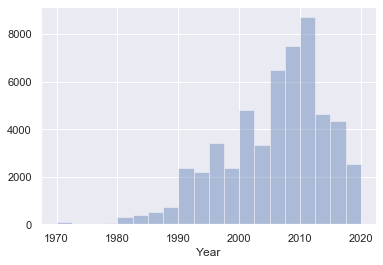

In [13]:
sns.distplot(df["Year"], kde=False, norm_hist=False, bins=20)
plt.show()

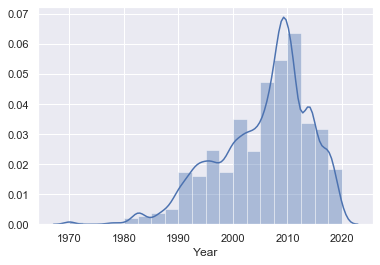

In [14]:
sns.distplot(df["Year"], hist=True, bins=20)
plt.show()

Видим, что пик выхода видео игр приходится на 2010-2012 годы.

Рискну предположить, что индустрия наполнялась проектами, после чего стало выгодным издавать только наиболее успешные и крупные.

## Шаг 2 - Определение популярности платформ

Построим вспомогательный график платформ, на которых выходило наибольшее количество игр за все время.

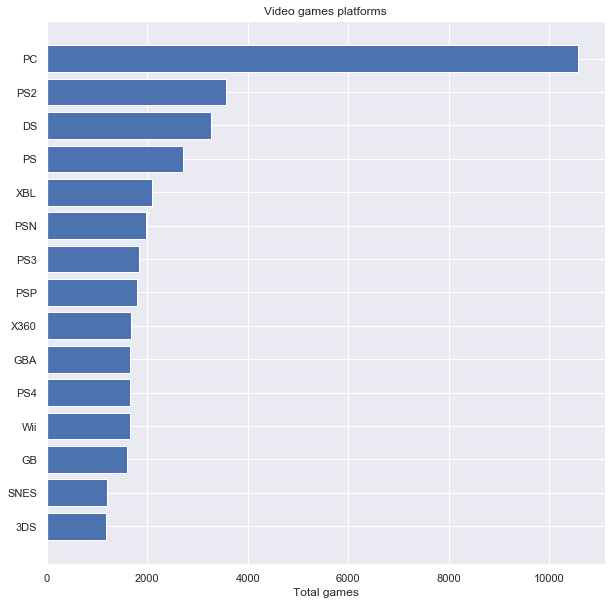

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

counts = df['Platform'].value_counts().sort_values(ascending=False).head(15)
ax.barh(counts.index, counts)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total games')
ax.set_title('Video games platforms')
plt.show()

Очевиден большой отрыв для ПК, там нет характерных для консолей "поколений", а значит все игры за все время объединены в один столбец.

## Шаг 3 - Определение количетсва игр на платформах

In [16]:
df_top_platforms = df.loc[df['Platform'].isin(counts.index)]
df_top_platforms.head()

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Year,Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006.0,82.86
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008.0,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017.0,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009.0,33.09
5,6,Pokemon Red / Green / Blue Version,Role-Playing,E,GB,Nintendo,Game Freak,9.4,NaN,1998.0,31.38


In [17]:
# Немного почистим выбросы
df_top_platforms = df_top_platforms.loc[(df_top_platforms['Year'] > 1970) | (df_top_platforms['Platform'] == 'PC')]

Очевидно, что должны наблюдаться последовательные пики количества игр на каждой платформе, т.к. среди платформ характерна концепция "смены поколений". Для визуалиции выберем Ridgeline.

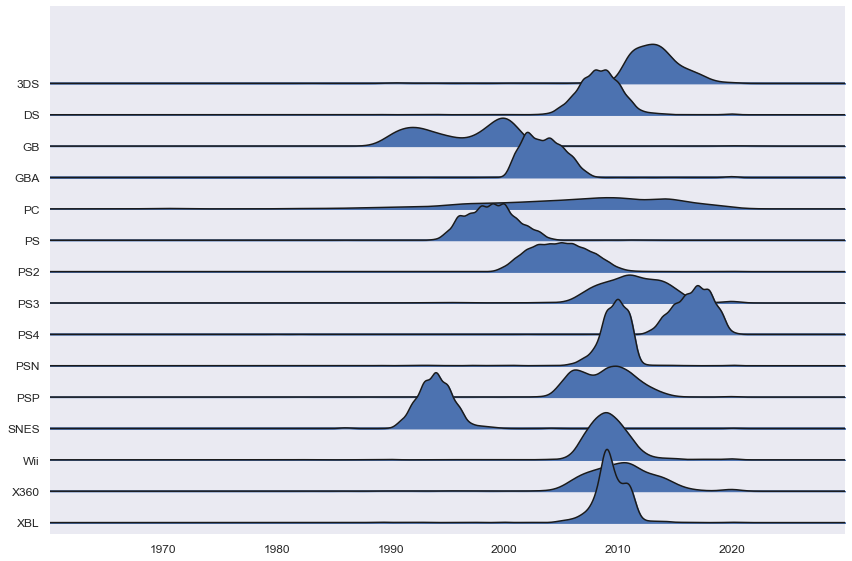

In [18]:
joyplot(
    data=df_top_platforms[['Year', 'Platform']], 
    by='Platform',
    figsize=(12, 8)
)
plt.show()

Видно, что для PC игры выходили на протяжении всего рассматриваемого периода, а количество выпускаемых игр на консоли сменяется поколениями консолей (отчетливо видно последовательность PS, PS2, PS3, PS4).

Для консолей, имеющих несколько ревизий отчетливо видны "пики". Так, для GameBoy можно выделить два пика - в 1991 (через год после выхода первой ревизии) и в 1999 (через год после выхода GameBoy Light). Для PSP аналогичная структура - пик через некоторое время после выхода первой ревизии, а затем еще один после выхода PSP-Go в 2009.

## Шаг 4 - Определение популярности жанров

Построим предварительный график, аналогичный шагу 2, но для жанров, чтобы отбросить самые редкие

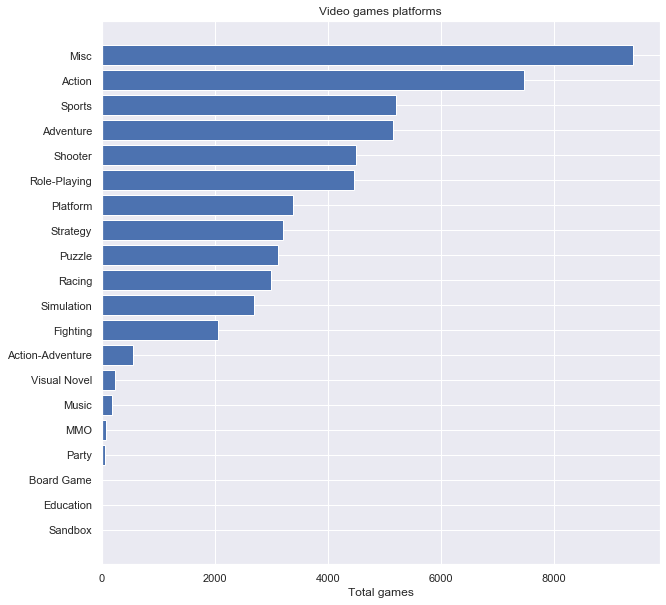

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

counts_genre = df['Genre'].value_counts().sort_values(ascending=False).head(20)
ax.barh(counts_genre.index, counts_genre)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total games')
ax.set_title('Video games platforms')
plt.show()

In [20]:
df_top_genre = df.loc[df['Genre'].isin(counts_genre.index)]
df_top_genre.head()

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Year,Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006.0,82.86
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985.0,40.24
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008.0,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017.0,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009.0,33.09


In [21]:
# Немного почистим выбросы
df_top_genre = df_top_genre.loc[(df_top_genre['Year'] > 1970) & (df_top_genre['Year'] <= 2019)]

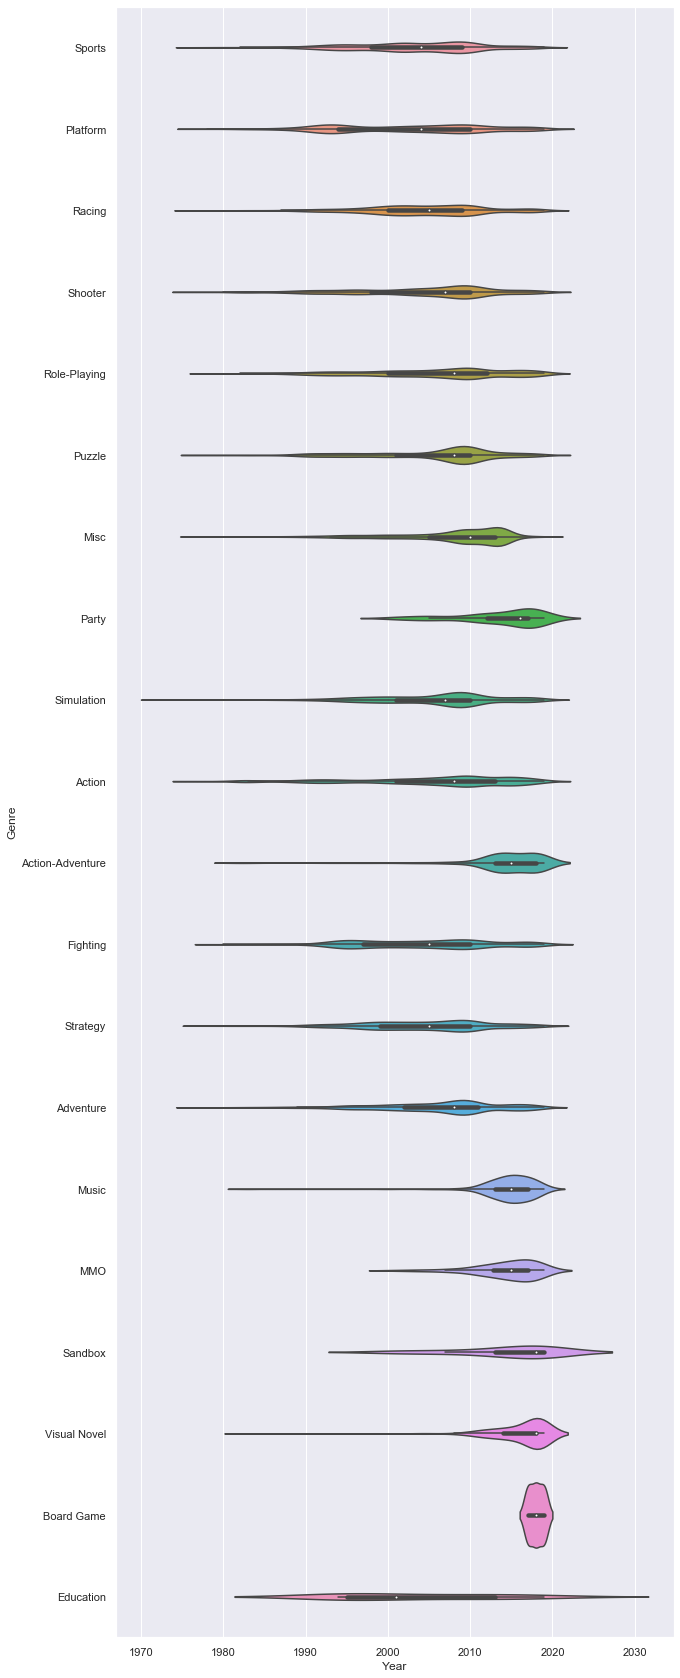

In [22]:
fig, ax = plt.subplots(figsize=(10, 30))
sns.violinplot(ax=ax, x=df_top_genre['Year'], y=df_top_genre['Genre'])
plt.show()

Наиболеее старым популярным жанром является платформер, первый пик его популярности приходится на начало 1990-ых (например игры Super Mario Bros, Metroid, итд).

До и после 2010 года с выходом консолей 7-го поколения (PS3, XBox360, Wii) наблюдается смена популярности жанров на появившиеся музыкальные игры, визуальные новеллы, и экшн-адвенчуры.

Занятно также, что жанр настольных видеоигр появился совсем недавно и пока не получил развития.

## Шаг 5 - Определение частоты наиболее популярных жанров на платформах

In [23]:
counts_genre.index

Index(['Misc', 'Action', 'Sports', 'Adventure', 'Shooter', 'Role-Playing',
       'Platform', 'Strategy', 'Puzzle', 'Racing', 'Simulation', 'Fighting',
       'Action-Adventure', 'Visual Novel', 'Music', 'MMO', 'Party',
       'Board Game', 'Education', 'Sandbox'],
      dtype='object')

In [24]:
df.groupby('Platform')['Genre'].value_counts()

Platform  Genre     
2600      Action        299
          Shooter        68
          Sports         39
          Misc           21
          Puzzle         19
                       ... 
iQue      Shooter         2
          Adventure       1
          Fighting        1
          Platform        1
          Simulation      1
Name: Genre, Length: 758, dtype: int64

In [25]:
platform_genre_df = pd.DataFrame()

for genre in counts_genre.index:
    selection = (df['Genre'] == genre) & (df['Platform'].isin(counts.index))
    platform_genre_df[genre] = df.loc[selection]['Platform'].value_counts()

In [26]:
# NaN = не было игр такого типа, заменим нулями
platform_genre_df = platform_genre_df.fillna(0)

In [27]:
# Нормализуем по каждой строке, чтобы PC не вызывал перекоса в сравнении с консолями
platform_genre_df = platform_genre_df.div(platform_genre_df.sum(axis=1), axis=0)

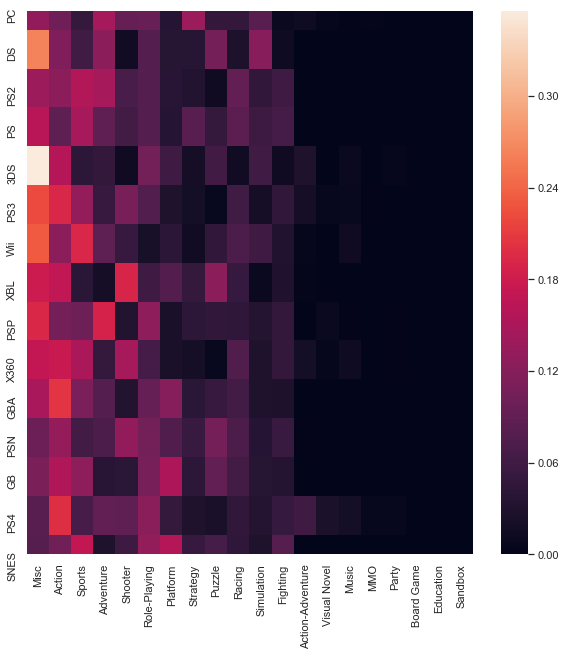

In [28]:
# Построим распределение жанров по платформам
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(platform_genre_df, ax=ax)
plt.show()

На всех платформах популярным оказался жанр Экшн и Другое. Однако у некоторых консолей наблюдается явная специализация в определенный жанр:

- PC: Стратегии (согласуется с высокой сложностью управления и наличием клавиатуры)
- SNES / GameBoy / GameBoy Advance: Платформеры (самые технологически простые игры)
- Wii: Спортивные (виртуальный финтенс Wii Sports самая продаваемая игра в списке)
- Xbox: Шутеры (лучшая производительность железа среди конкурентов)
- Playstation Portable: Приключения (продвинутые игры для портативной консоли)
- Nintendo DS/3DS: Другое (согласуется с уникальной особенностью консолей - два экрана)

## Выводы

Если учесть данные c шагов 3, 4 и 5 - можно сделать вывод, что игровая индустрия развивалась последовательно и годы выхода консолей совпадают с началом популярности определенных жанров.

Для более старых консолей NES, SNES, GameBoy - это платформеры. В 2010ых стали популярны спортивные игры из-за чего Wii стала самой продаваемой консолью и WiiSports самой продаваемой игрой. А для новых поколений консолей это приключения и шутеры. Что полностью совпадает с пиками популярности жанров и специализацией платформ.